# Project: China Scientific Leadership

**Notebook:** Fig2_b_China_US_Parity_by_Lead_Pro_threshold.ipynb

**Authors:** Renli Wu, Christopher Esposito, James Evans

**Affiliations:** School of Information Management, Wuhan University / Knowledge Lab, University of Chicago / University of California, Los Angeles

**Date:** 2024-11-29 (UTC)
**Version:** v0.3.0

**Purpose:**
This notebook generates **Figure 2b (Lead Share version)** for the main text and also produces the **Lead Premium version** (reported as **Fig. S3b** in the Supplementary Information).
Both the Lead Share and Lead Premium versions are equally important, as they provide complementary perspectives on leadership distribution.

In addition, the notebook can generate the supplementary figure (**Fig. S31**) for robustness checks.

**Inputs:**
- `data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz`

**Outputs:**
- `pics/fig_2_b_lead_share.svg`
- `pics/fig_2_b_lead_premium.svg`

**Notes:**
See `README.md` for details on environment setup, dependencies, and execution order within the full analysis pipeline.


In [1]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import sys

### Load the leadership dataset

In [2]:
%%time
print(time.strftime('%l:%M%p %Z on %b %d, %Y'))
data = pd.read_csv("./data/OpenAlex2023_Paper_Author_Lead_Pro_dataset.csv.gz", compression="gzip")
print(time.strftime('%l:%M%p %Z on %b %d, %Y'), data.shape)
data.head()

 5:20AM CDT on Sep 17, 2025


<timed exec>:2: DtypeWarning: Columns (9,14,15) have mixed types. Specify dtype option on import or set low_memory=False.


 5:22AM CDT on Sep 17, 2025 (42995311, 22)
CPU times: user 1min 58s, sys: 10.6 s, total: 2min 9s
Wall time: 2min 13s


,paperId,authorId,publication_year,Lead_Pro,region,China_US,China_EU+,China_UK,US_EU+,UK_EU+,...,China_BeltRoad_HighIncome,China_BeltRoad_LowIncome,US_BeltRoad_HighIncome,US_BeltRoad_LowIncome,jif_2021,jif_mid,11_technical_area,fos_6,Honorary_authors,Matched_in_WOS
0,W3135965258,A5021665664,2021,0.155624,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
1,W3135965258,A5032223512,2021,0.263628,East Asia,False,False,False,False,False,...,False,False,NaN,NaN,1-5,3.0,DIS;EG;HPC;MAT;SC,earth & life science;chemistry & materials sci...,False,True
2,W3135978430,A5058653785,2021,0.300942,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
3,W3135978430,A5062473161,2021,0.689903,EU+,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True
4,W3135978430,A5006524513,2021,0.242909,Latin America,False,False,False,False,False,...,False,False,NaN,NaN,5-10,7.5,DIS;EG;MAT,mathematics & physics & engineering;chemistry ...,False,True


In [3]:
### Main text - Fig 2(b) China-US Lead Parity By Different Lead Probability Thresholds

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from adjustText import adjust_text

In [5]:
# ---------- Parameters ----------
c1, c2 = "China", "U.S."
pair_col = f"{c1.replace('.', '')}_{c2.replace('.', '')}"
cols_needed = ["paperId","authorId","Lead_Pro","publication_year","region"]
year_tuple_list   = [(y, y) for y in range(2010, 2024)]
min_pub_per_year  = 200
future_years_grid = np.arange(2024, 2031).reshape(-1, 1)
conf_level        = 0.95

# Thresholds for Lead_Pro to evaluate
thd_former = np.arange(0, 0.61, 0.1)
thresholds = np.append(thd_former, [0.65, 0.7, 0.75])

# Colors
share_color   = "#f07167"
premium_color = "#0077b6"

In [6]:
# ---------- Helpers  ----------
def _bins(n=20):
    return np.linspace(0, 1, n+1)

def midpoint(iv: pd.Interval) -> float:
    return float(iv.mid)

def find_bounds_intersection_interval(year_grid, equal_line, X, x_mean, t_val, st_err, model):
    """Return [lower, upper] years where CI(mean prediction) encloses equal_line; else ("Never","Never")."""
    year_grid = np.asarray(year_grid, dtype=float).reshape(-1, 1)
    y_hat = model.predict(year_grid)
    n = len(X)
    sxx = float(np.sum((X - x_mean)**2))
    se_mean = st_err * np.sqrt(1/n + (year_grid - x_mean)**2 / sxx)

    lo = (y_hat - t_val * se_mean).ravel()
    hi = (y_hat + t_val * se_mean).ravel()
    mask = (lo <= equal_line) & (hi >= equal_line)
    if np.any(mask):
        idx = np.where(mask)[0]
        return int(year_grid[idx[0], 0]), int(year_grid[idx[-1], 0])
    return "Never", "Never"

def extract_start(s):
    """Sort key for labels like '0-1', '1-2', … ; returns +inf for 'inf'."""
    start_str = str(s).split('-')[0]
    return float('inf') if start_str in {'inf', 'Inf', 'INF'} else float(start_str)

In [7]:
# ---------- Data: subset to the target country pair ----------
obs = (
    data.loc[data[pair_col] == True, cols_needed]
        .drop_duplicates(["paperId","authorId","region"])
        .copy()
)

# ---------- 1) Build df_slope over (year × Lead_Pro threshold) ----------
slope_rows = []
val_bins = _bins(20)

for (st_year, end_year) in year_tuple_list:
    # one-year window
    sub_year = obs[obs["publication_year"].between(st_year, end_year)].copy()
    if sub_year.empty:
        continue
    pub_count = sub_year["paperId"].nunique()
    if pub_count <= min_pub_per_year:
        continue

    # bin Lead_Pro → counts per region × bin
    sub_year["val_bins"] = pd.cut(sub_year["Lead_Pro"], bins=val_bins, include_lowest=True)
    sta = (
        sub_year.groupby(["region","val_bins"], observed=True)
                .size().rename("count").reset_index()
    )
    sta["val_midpoints"] = sta["val_bins"].apply(midpoint).astype(float)

    # pivot to c1/c2 counts by lead-pro midpoint
    wide = (
        sta.pivot(index="val_midpoints", columns="region", values="count")
           .reindex(columns=[c1, c2])
           .fillna(0.0)
           .reset_index()
    )

    # compute metrics for each threshold
    for thd in thresholds:
        c1_lead  = wide.loc[wide["val_midpoints"] >  thd, c1].sum()
        c2_lead  = wide.loc[wide["val_midpoints"] >  thd, c2].sum()
        c1_musc  = wide.loc[wide["val_midpoints"] <= thd, c1].sum()
        c2_musc  = wide.loc[wide["val_midpoints"] <= thd, c2].sum()

        denom_lead = c1_lead + c2_lead
        denom_musc = c1_musc + c2_musc
        c1_lead_share = (c1_lead / denom_lead) if denom_lead > 0 else np.nan
        lead_premium  = (c1_lead / denom_lead - c1_musc / denom_musc) if (denom_lead > 0 and denom_musc > 0) else np.nan

        slope_rows.append([c1, c2, thd, c1_lead_share, lead_premium, st_year, end_year, pub_count])

df_slope = pd.DataFrame(
    slope_rows,
    columns=["c1","c2","lead_pro_thd","c1_lead_share","lead_premium","st_year","end_year","pub_num"]
)
df_slope["year"] = (df_slope["st_year"] + df_slope["end_year"]) / 2

# Keep thresholds with enough data across time
df_draw = df_slope[df_slope["pub_num"] >= 300].sort_values(by="st_year")

In [8]:
# ---------- 2) Regression & parity table by Lead_Pro threshold (revised & aligned with legacy scan logic) ----------
from sklearn.linear_model import LinearRegression
from scipy.stats import t as student_t

def _ci_bounds_at_year(x0, X, x_mean, t_val, st_err, sxx, n, model):
    """
    Mean-prediction confidence interval at a scalar year x0.
    Returns (lo, hi) as floats.
    """
    x0 = float(x0)
    y_hat = float(model.predict(np.array([[x0]])))
    se_mean = float(st_err * np.sqrt(1/n + ((x0 - x_mean) ** 2) / sxx))
    lo = y_hat - t_val * se_mean
    hi = y_hat + t_val * se_mean
    return lo, hi

def find_bounds_intersection_scan(year_iterable, equal_line, X, x_mean, t_val, st_err, model):
    """
    Compatible scan over integer years:
      - Walk years in year_iterable
      - Compute CI at each year and check if it encloses equal_line
      - lower = first year enclosed, upper = last year enclosed
      - Apply plausibility window [2000, 2300] to map out-of-range to "Never"
    Returns (lower_year, upper_year) with "Never" if not found or out of plausible range.
    """
    n = len(X)
    sxx = float(np.sum((X - x_mean) ** 2))
    lower, upper = None, None

    for yr in year_iterable:
        lo, hi = _ci_bounds_at_year(yr, X, x_mean, t_val, st_err, sxx, n, model)
        # use rounding similar to legacy code to avoid flicker around boundary
        if np.round(lo, 2) <= equal_line <= np.round(hi, 2):
            if lower is None:
                lower = int(yr)
            upper = int(yr)  # keep extending to latest enclosed

    # If none enclosed
    if lower is None:
        return "Never", "Never"

    # Plausibility window adjustment
    if lower <= 1999 or lower >= 2300:
        lower = "Never"
    if upper <= 1999 or upper >= 2300:
        upper = "Never"

    return lower, upper

def parity_table_by_threshold(df_draw, metric_col, equal_line, min_year=2010,
                              scan_year_start=2000, scan_year_end=2500, conf_level=0.95):
    """
    Compute:
      - mean-line parity year (catch_up_year)
      - CI-interval parity [lower_catch_up_year, upper_catch_up_year] via discrete scan
      - legend_text following interval rules (sorted; hi>2200 → "Parity after lo")
      - r_sq for diagnostics
    Returns a tidy DataFrame suitable for plotting.
    """
    recs = []
    for thd in np.sort(df_draw['lead_pro_thd'].unique()):
        cur = df_draw[(df_draw['lead_pro_thd'] == thd) &
                      (df_draw[metric_col].notna()) &
                      (df_draw["year"] >= min_year)]
        if cur.shape[0] < 3:
            continue

        X = cur['year'].to_numpy().reshape(-1, 1)
        Y = cur[metric_col].to_numpy().reshape(-1, 1)
        model = LinearRegression().fit(X, Y)
        r_sq  = float(model.score(X, Y))

        # CI components for current data
        y_pred = model.predict(X)
        resid  = Y - y_pred
        n      = len(X)
        if n <= 2:
            continue

        sse    = float(np.sum(resid**2))
        st_err = np.sqrt(sse / (n - 2))
        x_mean = float(np.mean(X))
        t_val  = float(student_t.ppf((1 + conf_level) / 2, df=n - 2))

        # CI parity interval via legacy-like scan over integer years
        lower_int, upper_int = find_bounds_intersection_scan(
            year_iterable=range(scan_year_start, scan_year_end),
            equal_line=equal_line, X=X, x_mean=x_mean, t_val=t_val, st_err=st_err, model=model
        )

        # Mean-line parity (solve a + b*year = equal_line)
        b = float(model.coef_.ravel()[0])
        a = float(model.intercept_.ravel()[0])
        catch_up = int(np.round((equal_line - a) / b)) if not np.isclose(b, 0) else "Never"
        if isinstance(catch_up, int) and (catch_up < 2000 or catch_up > 3000):
            catch_up = "Never"

        # Legend text rules (ascending interval; if hi>2200 → "Parity after lo")
        if upper_int == lower_int == "Never":
            legend_text = "Never Parity"
        elif "Never" in [lower_int, upper_int]:
            # ensure the non-"Never" value comes first
            lo, hi = (lower_int, upper_int) if lower_int != "Never" else (upper_int, lower_int)
            legend_text = f"Parity after {lo}"
        elif upper_int == lower_int:
            legend_text = f"Parity {upper_int}"
        else:
            lo, hi = sorted([lower_int, upper_int])
            legend_text = f"Parity after {lo}" if hi > 2200 else f"Parity {lo}-{hi}"

        recs.append([metric_col, thd, catch_up, upper_int, lower_int, r_sq, legend_text])

    out = pd.DataFrame(
        recs,
        columns=["type", "lead_pro_thd", "catch_up_year", "upper_catch_up_year", "lower_catch_up_year", "r_sq", "legend_text"]
    )
    return out

# Build final parity table for both metrics
df_cap_share = parity_table_by_threshold(df_draw, metric_col="c1_lead_share", equal_line=0.5,  min_year=2010)
df_cap_prem  = parity_table_by_threshold(df_draw, metric_col="lead_premium",  equal_line=0.0,  min_year=2010)
df_cap = pd.concat([df_cap_share, df_cap_prem], ignore_index=True)

# ---------- 3) Prepare plotting fields (handle "Never" for numeric y; keep legacy-compatible labels) ----------
# (Keep underscore columns for clarity; also mirror legacy hyphenated names for back-compatibility if needed)
df_cap["label"]        = df_cap["catch_up_year"].astype(str)
df_cap["upper_label"]  = df_cap["upper_catch_up_year"].astype(str)
df_cap["lower_label"]  = df_cap["lower_catch_up_year"].astype(str)


# Compute numeric placeholder for "Never"
never_year = max(
    pd.to_numeric(df_cap['upper_catch_up_year'], errors='coerce').max(),
    pd.to_numeric(df_cap['lower_catch_up_year'], errors='coerce').max(),
    pd.to_numeric(df_cap['catch_up_year'],        errors='coerce').max()
)
never_year = int((never_year if np.isfinite(never_year) else 2100) + 50)

# Numeric-only copy for plotting
dfp = df_cap.copy()
for col in ['upper_catch_up_year', 'lower_catch_up_year', 'catch_up_year']:
    dfp.loc[dfp[col] == "Never", col] = never_year
for col in ['upper_catch_up_year', 'lower_catch_up_year', 'catch_up_year']:
    dfp[col] = pd.to_numeric(dfp[col], errors='coerce')


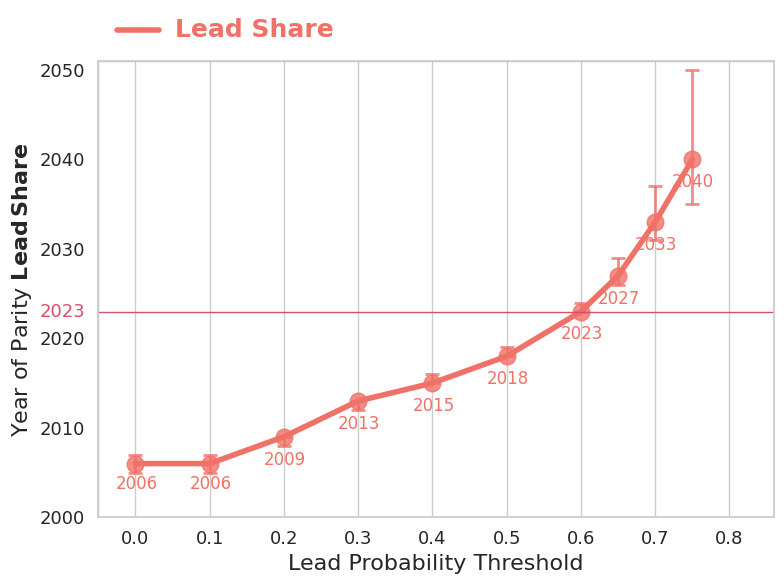

In [9]:
# ---------- 4) Plotting (two separate figures) ----------
sns.set_theme(style="whitegrid")

# --- Figure A: Lead Share parity vs Lead_Pro threshold ---
fig, ax1 = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

d_share = dfp[dfp['type'] == 'c1_lead_share'].copy().sort_values('lead_pro_thd')

# Line
sns.lineplot(x="lead_pro_thd", y="catch_up_year", data=d_share, ax=ax1, color=share_color, linewidth=4)

# Error bars
catch = d_share['catch_up_year'].astype(float).values
lo    = d_share['lower_catch_up_year'].astype(float).values
hi    = d_share['upper_catch_up_year'].astype(float).values
yerr_lower = np.maximum(catch - lo, 0.0)
yerr_upper = np.maximum(hi - catch, 0.0)
yerr = np.vstack([yerr_lower, yerr_upper])

ax1.errorbar(x=d_share['lead_pro_thd'].values, y=catch,
             yerr=yerr, fmt='o', ecolor=share_color, barsabove=True,
             elinewidth=2.0, capthick=2.0, alpha=0.8,
             color=share_color, capsize=5, markersize=12)

# Text labels near points
texts = []
for _, row in d_share.iterrows():
    texts.append(
        ax1.text(row['lead_pro_thd'], float(row['catch_up_year']) - 4,
                 f"{row['label']}", ha='center', va='bottom',
                 color=share_color,   fontsize=12)
    )
adjust_text(texts, only_move={'text':'y'}, expand_text=(1.1, 1.2), lim=5,
            autoalign='y', force_points=0.1, force_text=2)

# Reference & cosmetics
ax1.axhline(2023, color='#DB4D6D', linestyle='-', linewidth=1)
ax1.annotate('2023', xy=(-0.068, 2023), xycoords=('data', 'data'),
             va='center', ha='right', color='#DB4D6D', fontsize=13)
ax1.yaxis.grid(False)
ax1.set_ylabel(r"Year of Parity $\bf{Lead}\,\bf{Share}$", fontsize=16)
ax1.set_xlabel("Lead Probability Threshold", fontsize=16)

leg1 = ax1.legend(['Lead Share'], loc='lower left', bbox_to_anchor=(0, 1),
                  prop={'weight':'semibold','size':15}, frameon=False)
for text in leg1.get_texts():
    text.set_color(share_color); text.set_fontsize(18); text.set_weight('bold')

ax1.set_xlim([-0.05, 0.86])
ax1.set_xticks(np.arange(0, 0.9, 0.1))
ax1.set_xticklabels([f"{x:.1f}" for x in np.arange(0, 0.9, 0.1)], fontsize=13)

ax1.set_ylim(2000, 2051)
ax1.set_yticks(range(2000, 2051, 10))
ax1.set_yticklabels(range(2000, 2051, 10))
for lbl in ax1.get_yticklabels():
    lbl.set_fontsize(13)

# Border rectangle
x0, x1 = ax1.get_xlim(); y0, y1 = ax1.get_ylim()
rect = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='grey', facecolor='none', alpha=0.5)
ax1.add_patch(rect)
plt.tight_layout()
plt.savefig(f"./pics/fig_2_b_lead_share.svg",
            facecolor='white', bbox_inches='tight', format="svg", dpi=300)
plt.show()

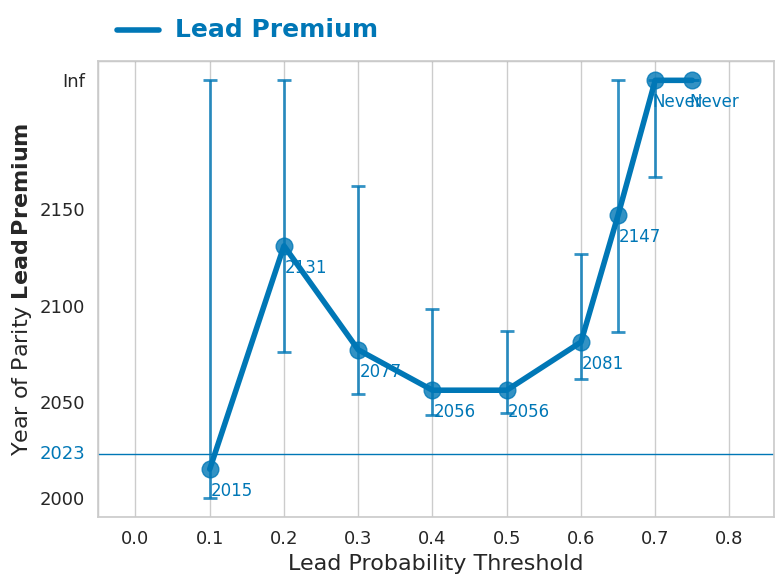

In [10]:

# --- Figure B: Lead Premium parity vs Lead_Pro threshold ---
fig, ax2 = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('white')

d_prem = dfp[dfp['type'] == 'lead_premium'].copy().sort_values('lead_pro_thd')

sns.lineplot(x="lead_pro_thd", y="catch_up_year", data=d_prem, ax=ax2, color=premium_color, linewidth=4)

catch = d_prem['catch_up_year'].astype(float).values
lo    = d_prem['lower_catch_up_year'].astype(float).values
hi    = d_prem['upper_catch_up_year'].astype(float).values
yerr_lower = np.maximum(catch - lo, 0.0)
yerr_upper = np.maximum(hi - catch, 0.0)
yerr = np.vstack([yerr_lower, yerr_upper])

ax2.errorbar(x=d_prem['lead_pro_thd'].values, y=catch,
             yerr=yerr, fmt='o', ecolor=premium_color, barsabove=True,
             elinewidth=2.0, capthick=2.0, alpha=0.8,
             color=premium_color, capsize=5, markersize=12)

# Label each point (slightly above)
for _, row in d_prem.iterrows():
    ax2.text(row['lead_pro_thd'] + 0.03, float(row['catch_up_year']) - 16,
             f"{row['label']}", ha='center', va='bottom',
             color=premium_color,  fontsize=12)

ax2.axhline(2023, color=premium_color, linestyle='-', linewidth=1)
ax2.annotate('2023', xy=(-0.068, 2023), xycoords=('data','data'),
             va='center', ha='right', color=premium_color,  fontsize=13)
ax2.yaxis.grid(False)
ax2.set_ylabel(r"Year of Parity $\bf{Lead}\,\bf{Premium}$", fontsize=16)
ax2.set_xlabel("Lead Probability Threshold", fontsize=16)

leg2 = ax2.legend(['Lead Premium'], loc='lower left', bbox_to_anchor=(0, 1),
                  prop={'weight':'semibold','size':15}, frameon=False)
for text in leg2.get_texts():
    text.set_color(premium_color); text.set_fontsize(18); text.set_weight('bold')

ax2.set_xlim([-0.05, 0.86])
ax2.set_xticks(np.arange(0, 0.9, 0.1))
ax2.set_xticklabels([f"{x:.1f}" for x in np.arange(0, 0.9, 0.1)], fontsize=13)

# Premium panel often spans further; use "Inf" if needed
upper_y = max(2050, int(never_year) + 10)
ax2.set_ylim(1990, upper_y)
yticks = list(range(2000, min(upper_y, 2151), 50))
if upper_y > 2100:
    yticks = yticks + [never_year]
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(y) if y != never_year else "Inf" for y in yticks])
for lbl in ax2.get_yticklabels():
    lbl.set_fontsize(13)

# Border rectangle
x0, x1 = ax2.get_xlim(); y0, y1 = ax2.get_ylim()
rect2 = patches.Rectangle((x0, y0), x1-x0, y1-y0, linewidth=1, edgecolor='grey', facecolor='none', alpha=0.5)
ax2.add_patch(rect2)
plt.tight_layout()
plt.savefig(f"./pics/fig_2_b_lead_premium.svg",
            facecolor='white', bbox_inches='tight', format="svg", dpi=300)
plt.show()